In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from video import *
import numpy as np
import ultralytics
import cv2 as cv
from utils import *
from tqdm import tqdm 
from ultralytics import RTDETR

In [3]:
fundamental_matrices = {
    "A" : {
        "B": np.load("fundamental_matrices/AB.npy"),
        "C": np.load("fundamental_matrices/AC.npy"),
    },
    "B": {
        "A": np.load("fundamental_matrices/BA.npy"),
        "C": np.load("fundamental_matrices/BC.npy"),
    },
    "C": {
        "B": np.load("fundamental_matrices/CB.npy"),
        "A": np.load("fundamental_matrices/CA.npy"),
    }
}

In [113]:
homography_matrices = {
    "A" : {
        "B": np.load("homography_matrices/AB.npy"),
        "C": np.load("homography_matrices/AC.npy"),
    },
    "B": {
        "A": np.load("homography_matrices/BA.npy"),
        "C": np.load("homography_matrices/BC.npy"),
    },
    "C": {
        "B": np.load("homography_matrices/CB.npy"),
        "A": np.load("homography_matrices/CA.npy"),
    }
}

In [4]:
#model = YOLO("yolov9e.pt")
#model.track("train/task1/02_query.mp4", show=True, tracker="./trackers/bytetrack.yaml", conf=0.1, iou=0.1, agnostic_nms=True, augment=True, max_det=1000) 

In [4]:
if 'query' in globals():
    del query
if 'reference' in globals():
    del reference

query = load_video("train/task1/01_query.mp4")
reference = load_video("train/task1/01_reference.mp4")

In [5]:
query.do_tracking()
reference.do_tracking()

In [6]:
camera_query = query.get_camera()
camera_reference = reference.get_camera()

print("Query camera:", camera_query)
print("Reference camera:", camera_reference)

Query camera: C
Reference camera: B


In [7]:
F = fundamental_matrices[camera_query][camera_reference] 
print(F)
F_inv = fundamental_matrices[camera_reference][camera_query] 
print(F_inv)

[[ 2.5012e-08  1.0537e-06 -0.00034678]
 [ 1.0474e-06  1.0097e-07  -0.0015508]
 [-0.00053031 -0.00078029           1]]
[[ 2.5012e-08  1.0474e-06 -0.00053031]
 [ 1.0537e-06  1.0097e-07 -0.00078029]
 [-0.00034678  -0.0015508           1]]


In [114]:
H = homography_matrices[camera_query][camera_reference]
print(H)
H_inv = homography_matrices[camera_reference][camera_query]
print(H_inv)

[[     1.2631     -1.3538     -1503.1]
 [    0.20802     -2.0654      307.52]
 [ 0.00032342  -0.0032521           1]]
[[    0.47153     -3.2003      1761.2]
 [   -0.02866    -0.65045      114.33]
 [-0.00011385  -0.0016827           1]]


In [115]:
query_index = 1 
reference_index = 270 

In [ ]:

# Removes those points that would be outside the frame when transformed to the other camera's frame.
def filter_points_homography(points, H):
    transformed_points = cv.perspectiveTransform(points.reshape(-1, 1, 2).astype(np.float32), H).squeeze()

    in_bounds = np.logical_and(
        np.logical_and(transformed_points[:, 0] >= 0, transformed_points[:, 0] < FRAME_WIDTH),
        np.logical_and(transformed_points[:, 1] >= 0, transformed_points[:, 1] < FRAME_HEIGHT)
    )

    return points[in_bounds]


In [144]:
def similarity_epipolar(query, reference, visualize=False):
    moving_pixels_query = query.moving_pixels()
    moving_pixels_reference = reference.moving_pixels()

    # Get the actual coordinates of the moving pixels
    rows, cols = np.where(moving_pixels_query)
    points_query = np.stack((cols, rows), axis=1) 

    rows, cols = np.where(moving_pixels_reference)
    points_reference = np.stack((cols, rows), axis=1) 

    if len(points_query) == 0 or len(points_reference) == 0:
        return None

    # Filter points that would be outside the frame when transformed to the other camera's frame.
    points_query = filter_points_homography(points_query, H)
    points_reference = filter_points_homography(points_reference, H_inv)

    if len(points_query) == 0 or len(points_reference) == 0:
        return None

    # Downsample points to avoid too many points
    if len(points_query) > 3000:
        indices = np.random.choice(len(points_query), 3000, replace=False)
        points_query = points_query[indices]

    if len(points_reference) > 3000:
        indices = np.random.choice(len(points_reference), 3000, replace=False)
        points_reference = points_reference[indices]

    # Compute the epipolar lines for the query points in the reference frame.
    lines = cv.computeCorrespondEpilines(points_query.reshape(-1, 1, 2), 1, F).squeeze()
    score = 0

    # Just prepare the plots if visualization is enabled.
    if visualize:
        query_plot = query.raw().copy()
        reference_plot = reference.raw().copy()

    chosen = np.zeros(len(points_reference), dtype=bool)
    for i, line in enumerate(lines):
        points_to_check = points_reference[~chosen]
        distances = distance_point_to_line(points_to_check, line)

        minimum_index = np.argmin(distances)
        minimum_distance = distances[minimum_index]

        if minimum_distance < 5:
            score+=1

            # Mark this point as chosen so we don't use it again.
            chosen[minimum_index] = True

            if visualize:
                color = np.random.randint(0, 255, size=3).tolist()
                cv.circle(query_plot, (points_query[i][0], points_query[i][1]), 10, color, -1)
                close_point = points_reference[minimum_index]
                cv.circle(reference_plot, (close_point[0], close_point[1]), 10, color, -1)
    
    if visualize:
        fig, axs = plt.subplots(1, 2, figsize=(20, 30))
        axs[0].imshow(moving_pixels_query)
        axs[1].imshow(moving_pixels_reference)
        plt.show()
        
        fig, axs = plt.subplots(1, 2, figsize=(20, 30))
        axs[0].imshow(query_plot)
        axs[0].set_title("Query Frame")
        axs[0].axis('off')
        axs[1].imshow(reference_plot)
        axs[1].set_title("Reference Frame")
        axs[1].axis('off')
        plt.show()

    return score

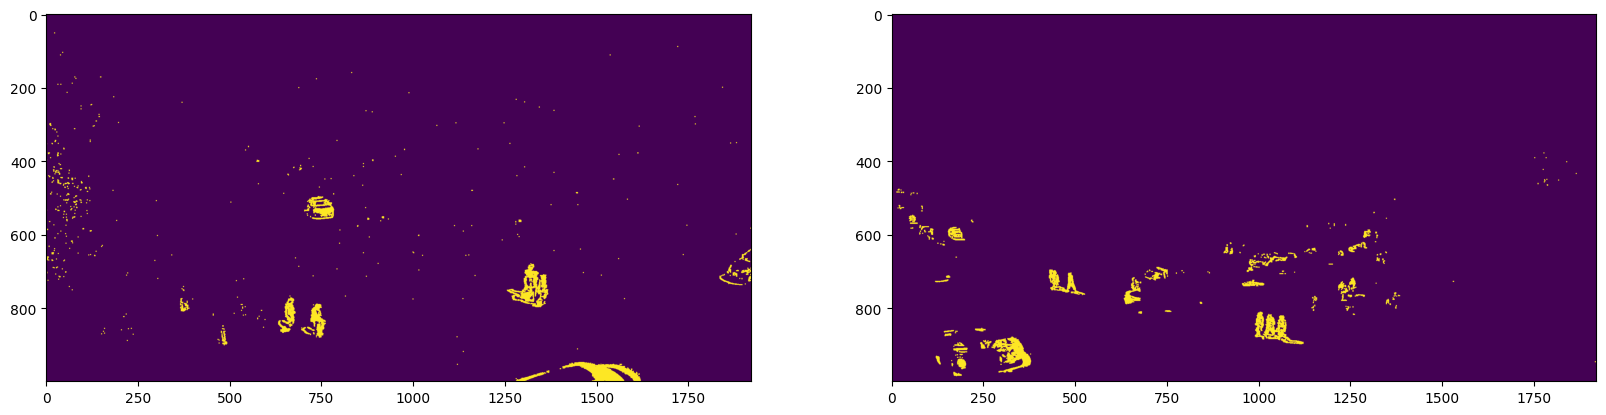

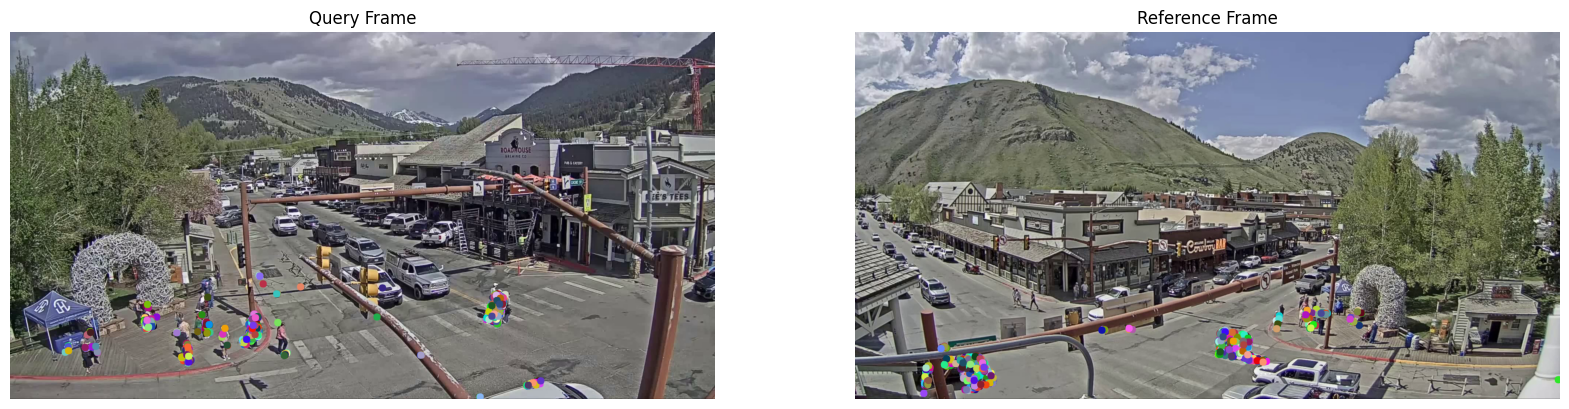

879


In [145]:
similarity_score = similarity_epipolar(query.get_frame(query_index), reference.get_frame(reference_index), 
                              visualize=True)
print(similarity_score)

In [142]:
num_query_frames = query.num_frames()
num_reference_frames = reference.num_frames()
print(num_query_frames)
costs = []

min_cost = np.inf 
best_frame_pair = None

for i in range(0, num_reference_frames-num_query_frames+1, 10):
    total_cost = 0

    for t in range(0, num_query_frames, 10):
        cost = similarity_epipolar(query.get_frame(t), reference.get_frame(i+t))
        if cost is not None:
            total_cost += cost
        
    costs.append(total_cost)
    print(f"Frame {i}: cost = {total_cost}")

180
Frame 0: cost = 8626
Frame 10: cost = 9560
Frame 20: cost = 10625
Frame 30: cost = 11706
Frame 40: cost = 12489
Frame 50: cost = 13408
Frame 60: cost = 14070
Frame 70: cost = 15273
Frame 80: cost = 15891
Frame 90: cost = 16148
Frame 100: cost = 16823
Frame 110: cost = 17776
Frame 120: cost = 18620
Frame 130: cost = 20239
Frame 140: cost = 22207
Frame 150: cost = 23248
Frame 160: cost = 24351
Frame 170: cost = 24720
Frame 180: cost = 24435
Frame 190: cost = 24290
Frame 200: cost = 23043
Frame 210: cost = 22204
Frame 220: cost = 20182
Frame 230: cost = 19533
Frame 240: cost = 17720
Frame 250: cost = 18541
Frame 260: cost = 18712
Frame 270: cost = 18732
Frame 280: cost = 18844
Frame 290: cost = 19708
Frame 300: cost = 20555
Frame 310: cost = 21053
Frame 320: cost = 19861
Frame 330: cost = 18192
Frame 340: cost = 16396
Frame 350: cost = 14408
Frame 360: cost = 12326
Frame 370: cost = 10567
Frame 380: cost = 9103
Frame 390: cost = 7806
Frame 400: cost = 7759
Frame 410: cost = 8933
Frame

58
None


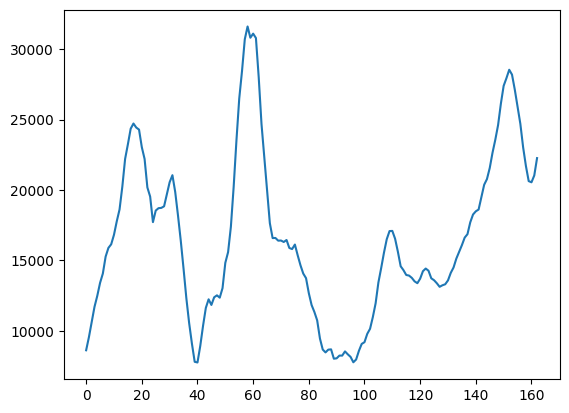

In [143]:
plt.plot(costs)
print(np.argmax(costs))
print(best_frame_pair)

70
None


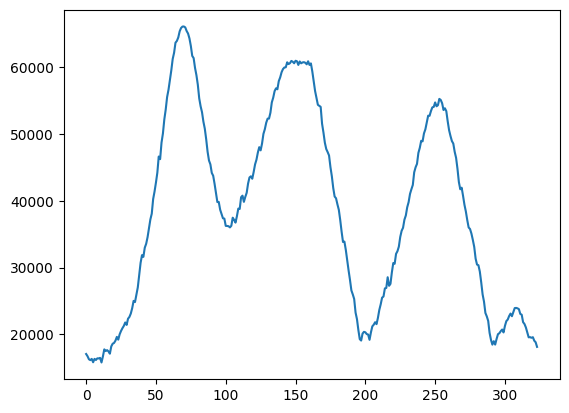

In [109]:
plt.plot(costs)
print(np.argmax(costs))
print(best_frame_pair)